**Importing Librairies**

In [1]:
import pandas as pd
import numpy as np 


import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from time import time
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**1. 1st Data Set:Kaggle**







1.1 Global variables

In [5]:
#global variables
df = pd.read_csv('emotion.csv')
stopwords = nltk.corpus.stopwords.words("english")
targets = df['Emotion']
corpus = df['Text']

In [6]:
# count vectorizer using SKlearn
vect = CountVectorizer(stop_words = stopwords)
X = vect.fit_transform(corpus)
words = vect.get_feature_names()

1.2 Data Visualisation

In [7]:
#Data visualisation
wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

# Sub-sample the data to plot.
# take the 20 first + the rest sample with the given step 
def subsample(x, step=900):
    return np.hstack((x[:20], x[20::step]))

freq = subsample(wrank)
r = np.arange(len(freq))

In [8]:
x = subsample(labels)
y = freq
trace = go.Bar(
                x = x,
                y = y,
                name = "Words ordered by rank. The first rank is the most frequent words and the last one is the less present",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line = dict(color ='rgb(0,0,0)',width =1.5)))
               

layout = go.Layout(barmode = "group")
fig = go.Figure(data = trace, layout = layout)
fig.show()

In [9]:
fig = go.Figure()
fig = go.Figure(data=[go.Histogram(x= targets, name='Emotions')], 
                     
               layout = {
                   'title':'Emotions Histogram',
                   'xaxis_title_text': 'Emotions',
                   'yaxis_title_text': 'frequence'})
            

fig.show()

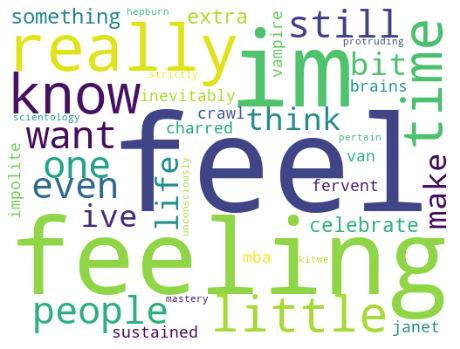

In [ ]:
x = subsample(labels)

plt.subplots(figsize=(8,8))
wordcloud = WordCloud(
                          background_color='white',
                          width=512,
                          height=384
                         ).generate(" ".join(x))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')

plt.show()

**Observations-commentaires des graphiques:**


- J'ai fait le choix d'enlever uniquement les mots faisant partie des stop words pour ne dénaturaliser le jeux de données.  
- La classe Happy est celle qui englobe le plus de message. Elle sera probablement la plus facile à prédire. 


1.3 Classification usig Sklearn

In [ ]:
targets1 = df['Emotion']
targets1 = np.array([1 if x == "sadness" else 2 if x=="anger" else 3 if x=="love" else 4 if x=="surprise" else 5 if x=="fear" else 6 for x in targets1])

In [10]:
# count vectorizer with python (and nltk for the lemmatization)
X1 = []
X2 = []
lemmatizer = nltk.WordNetLemmatizer() # english
voc = set()
for doc in corpus:
    # tokenize
    v = doc.split()
    # take lower case
    vv = [x.lower() for x in v]
    # remove stopwords
    vvv = [x for x in vv if x not in stopwords]
    # remove punction ...
    vvvv = [lemmatizer.lemmatize(x) for x in vvv]
    # build vocabulary
    for word in vvvv:
        voc.add(word)
    X1.append(vvvv)

for d in X1:
    # count words
    x = [d.count(w) for w in voc]
    X2.append(x)

In [11]:
pipe0 = Pipeline([
    ('vect', CountVectorizer()),
    ('sgd', SGDClassifier()),
])
pipe1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
])
pipe2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svml', LinearSVC()),
])

pipe3 = Pipeline([
    ('vect', CountVectorizer()),
    ('logit', LogisticRegression(max_iter= 3000)),
])
pipe4 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logit1', LogisticRegression(max_iter= 3000)),
])
def run_pipes(pipes, splits, test_size=0.2, seed=42):
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed) #mélange
    for idx_train, idx_test in spliter.split(corpus): #
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])

            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]

            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start

            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                #f1_score(y_test, y, pos_label=1,average='weighted'),   #average setting, one of [None, 'micro', 'macro', 'weighted'].
                f1_score(y_test, y, average='weighted'),
                f1_score(y_test, y, average= 'macro')

                #f1_score(y_test, y, pos_label=0),
            ])
    return res

def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0].mean().round(2),
            "f1_weighted": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_macro": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
            "Precision" : arr[:,2].mean().round(3),
            "Recall" : arr[:,2].mean().round(3)
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [13]:
res = run_pipes([pipe0, pipe1, pipe2, pipe3, pipe4], splits=1)
filenamexx = pickle.dump(res, open("res1.joblib", "wb"))
print_table(res)

,time,f1_weighted,f1_macro,Precision,Recall
vect-sgd,0.76,"[0.893, 0.0]","[0.855, 0.0]",0.855,0.855
vect-tfidf-sgd,0.60,"[0.893, 0.0]","[0.857, 0.0]",0.857,0.857
vect-tfidf-svml,0.73,"[0.901, 0.0]","[0.864, 0.0]",0.864,0.864
vect-logit,11.40,"[0.893, 0.0]","[0.856, 0.0]",0.856,0.856
vect-tfidf-logit1,8.18,"[0.855, 0.0]","[0.802, 0.0]",0.802,0.802


**Commentaire classification:**
- Scores correctes et logiques!!
- Temps d'éxécution plutôt raisonnable.
- Cela peut être expliqué par la qualité du jeux de données(propre et de petite taille)

2. 2nd Data Set: Data World

2.2 Global Variables

In [14]:
df2 = pd.read_csv('https://query.data.world/s/jq7lk27hbmlg2t5rf4tqoksxnrs4fl')
stopwords = nltk.corpus.stopwords.words("english")
corpus2 = df2['content']
targets2 = df2['sentiment']
vect = CountVectorizer(stop_words = stopwords)
X2 = vect.fit_transform(corpus2)
words = vect.get_feature_names()

2.3 Data Visualisation

In [ ]:
fig = go.Figure()
fig = go.Figure(data=[go.Histogram(x= targets2, name='Emotions')], 
                     
               layout = {
                   'title':'Emotions Histogram',
                   'xaxis_title_text': 'Emotions',
                   'yaxis_title_text': 'frequence'})
            

fig.show()

In [ ]:
x = subsample(labels)
y = freq
trace = go.Bar(
                x = x,
                y = y,
                name = "Words ordered by rank. The first rank is the most frequent words and the last one is the less present",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line = dict(color ='rgb(0,0,0)',width =1.5)))
layout = go.Layout(barmode = "group")
fig = go.Figure(data = trace, layout = layout)
fig.show()

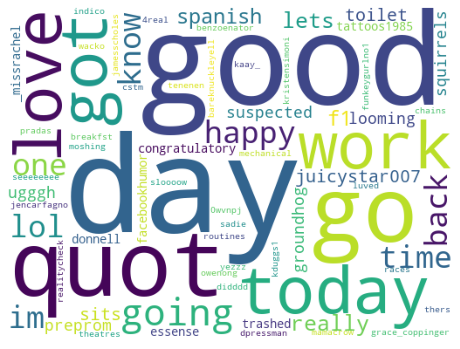

In [ ]:
x = subsample(labels)

plt.subplots(figsize=(8,8))
wordcloud = WordCloud(
                          background_color='white',
                          width=512,
                          height=384
                         ).generate(" ".join(x))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')

plt.show()

2.3 Classification usig Sklearn

In [15]:
targets2 = targets2.replace ('happiness', 'happy')
targets2 = np.array([1 if x == "empty" else 2 if x=="sadness" else 3 if x=="enthusiasm" else 4 if x=="neutral" else 5 if x=="worry" else 6 if x == "surprise" else 7 if x=="love" else 8 if x=="fun" else 9 if x=="hate" else 10 if x=="happy" else 11 if x=="boredom" else 12 if x=="relief" else 13 if x=="anger" else 14 for x in targets2])

In [16]:
pipe5 = Pipeline([
    ('vect', CountVectorizer()),
    ('sgd', SGDClassifier()),
])
pipe6 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
])
pipe7 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svml', LinearSVC()),
])

pipe8 = Pipeline([
    ('vect', CountVectorizer()),
    ('logit', LogisticRegression(max_iter= 3000)),
])
pipe9 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logit1', LogisticRegression(max_iter= 3000)),
])
def run_pipes(pipes, splits, test_size=0.2, seed=42):
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed) #mélange
    for idx_train, idx_test in spliter.split(corpus): #
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])

            # extract datasets
            X_train = corpus2[idx_train]
            X_test = corpus2[idx_test]
            y_train = targets2[idx_train]
            y_test = targets2[idx_test]

            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start

            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                #f1_score(y_test, y, pos_label=1,average='weighted'),   #average setting, one of [None, 'micro', 'macro', 'weighted'].
                f1_score(y_test, y, average='weighted'),
                f1_score(y_test, y, average= 'macro')

                #f1_score(y_test, y, pos_label=0),
            ])
    return res
def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0].mean().round(2),
            "f1_weighted": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_macro": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
            "Precision": arr[:,2].mean().round(3),
            "Recall": arr[:,2].mean().round(3)
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [17]:
res = run_pipes([pipe5, pipe6, pipe7, pipe8, pipe9], splits=1)
filename2 = pickle.dump(res, open("res2.joblib", "wb"))
print_table(res)

,time,f1_weighted,f1_macro,Precision,Recall
vect-sgd,1.23,"[0.285, 0.0]","[0.149, 0.0]",0.149,0.149
vect-tfidf-sgd,0.71,"[0.29, 0.0]","[0.142, 0.0]",0.142,0.142
vect-tfidf-svml,1.01,"[0.285, 0.0]","[0.14, 0.0]",0.140,0.140
vect-logit,23.95,"[0.298, 0.0]","[0.149, 0.0]",0.149,0.149
vect-tfidf-logit1,18.75,"[0.291, 0.0]","[0.13, 0.0]",0.130,0.130


**Commentaires classifications:**

Les scores liés à ce jeux de données sont faibles. En tenant compte du poids des classes (avec le f1 weighted), les scores s'améliorent légérement. On remarque que le SGD Classifieur donne un meilleur score pondéré (f1 weighted) en moins de temps.

Ces scores peuvent expliqués par le fait que ce data set est composé de vrais tweets. La prédiction est donc plus difficile étant donnée que la frontière entre les émotions est assez fine. Egalement, la ponctuation et les émoticons, qui ne sont pas analysés par ces classifieurs, peuvent donner une meilleure idée sur l'émotion derrière chaque message. 



3. Global Data Set

3.1 Global variables

In [18]:
X1 = df['Text']
X2 = df2['content']
XX = pd.concat([X1, X2])
XX2 = vect.fit_transform(XX)

y1 = df['Emotion']
y2 = df2['sentiment']
YY = pd.concat([y1,y2])

YY2 = np.array([1 if x == "sadness" else 2 if x=="anger" else 3 if x=="love" else 4 if x=="surprise" else 5 if x=="fear" else 6 if x == "happy" or x=="hapiness" else 7 if x=="empty" else 8 if x=="enthousiasm" else 9 if x=="neutral" else 10 if x=="worry" else 11 if x == "fun" else 12 if x=="hate" else 13 if x=="boredom" else 14 for x in YY])

3.2 Data Visualisation

In [19]:
fig = go.Figure()
fig = go.Figure(data=[go.Histogram(x= YY, name='Emotions')], 
                     
               layout = {
                   'title':'Emotions Histogram',
                   'xaxis_title_text': 'emotions',
                   'yaxis_title_text': 'frequence'})
            

fig.show()

In [20]:
pipe10 = Pipeline([
    ('vect', CountVectorizer()),
    ('sgd', SGDClassifier()),
])
pipe11 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
])
pipe12 =  Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svml', LinearSVC()),
])

pipe13 = Pipeline([
    ('vect', CountVectorizer()),
    ('logit', LogisticRegression(max_iter= 3000)),
])
pipe14 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logit1', LogisticRegression(max_iter= 3000)),
])
def run_pipes(pipes, splits, test_size=0.2, seed=42):
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed) #mélange
    for idx_train, idx_test in spliter.split(XX): #
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])

            # extract datasets
            X_train = np.array(XX)[idx_train]
            X_test = np.array(XX)[idx_test]
            y_train = np.array(YY2)[idx_train]
            y_test = np.array(YY2)[idx_test]

            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start

            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                #f1_score(y_test, y, pos_label=1,average='weighted'),   #average setting, one of [None, 'micro', 'macro', 'weighted'].
                f1_score(y_test, y, average='weighted'),
                f1_score(y_test, y, average= 'macro')

                #f1_score(y_test, y, pos_label=0),
            ])
    return res

def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0].mean().round(2),
            "f1_weighted": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_macro": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
            "Precision" : arr[:,2].mean().round(3),
            "Recall" : arr[:,2].mean().round(3)
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [23]:
filename4 = pickle.dump(res, open("res3.joblib", "wb"))
res = run_pipes([pipe10, pipe11, pipe12, pipe13, pipe14], splits=1)
print_table(res)

,time,f1_weighted,f1_macro,Precision,Recall
vect-sgd,3.45,"[0.511, 0.0]","[0.414, 0.0]",0.414,0.414
vect-tfidf-sgd,2.41,"[0.485, 0.0]","[0.395, 0.0]",0.395,0.395
vect-tfidf-svml,4.71,"[0.498, 0.0]","[0.407, 0.0]",0.407,0.407
vect-logit,75.32,"[0.515, 0.0]","[0.418, 0.0]",0.418,0.418
vect-tfidf-logit1,54.60,"[0.508, 0.0]","[0.403, 0.0]",0.403,0.403


**Commentaires classifications:**

Les scores de jeux de données global (issu de la concaténation des 2 data set) sont meilleurs que ceux du deuxième mais pas assez suffisants pour donner des prédiction efficaces. On remarque également que le temps d'éxécution est assez long pour la Regression Logistique. 
L'amélioration des scores peut être expliquée par la présence du 1er data set. Malgré qu'il représente le tiers du jeus de données global, il permet d'améliorer les scores de 4 points. 